<a href="https://colab.research.google.com/github/hareidx/FASTAI_HAREID/blob/main/FASTAI_Week_01_My_Own_Take_Version_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FAST AI Week 01 - My Own Take Version 2

In [1]:
!pip install -Uqq fastai

     |████████████████████████████████| 197 kB 12.2 MB/s 
     |████████████████████████████████| 60 kB 3.2 MB/s 


In [4]:
# begin imports
from fastai.vision.all import *
from fastcore.all import *
from fastdownload import download_url
import time

In [17]:
# create function for searching for and locating images from Duck Duck Go
def search_images(term, max_images=300) -> "L(urls)[:max_images]":
  url = 'https://duckduckgo.com/'
  res = urlread(url,data={'q':term})
  searchObj = re.search(r'vqd=([\d-]+)\&', res)
  requestUrl = url + 'i.js'
  params = dict(l='us=en', o='json', q=term, vqd=searchObj.group(1), f=',,,', p='1', v7exp='a')
  urls,data = set(), {'next':1}
  while len(urls)<max_images and 'next' in data:
    data = urljson(requestUrl, data=params)
    urls.update(L(data['results']).itemgot('image'))
    requestUrl = url + data['next']
    time.sleep(0.2)
  return L(urls)[:max_images]
  
def search(term: str) -> None:
  """ Search for a single thing """
  urls = search_images(term, max_images=1)
  urls[0]
  dest = f'{term}.jpg'
  #dest = term+'.jpg'
  download_url(urls[0], dest, show_progress=False)
  im = Image.open(dest)
  im.to_thumb(256,256)

def begin_search(base: str, comparable: str):
  """Run a search on a base image type and its comparable/anti"""
  search(base)
  search(comparable)

  searches = base, comparable
  path = Path(f'{base}_or_{comparable}')
  for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    resize_images(path/o, max_size=400, dest=path/o)

  # remove failed downloads
  failed = verify_images(get_image_files(path))
  failed.map(Path.unlink)
  print(f'There were {len(failed)} failed images')    

  # set up model
  dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
  ).dataloaders(path)

  dls.show_batch(max_n=10)
  train_model(base, dls)

def train_model(base: str, dls: DataBlock) -> None:
  learn = vision_learner(dls, resnet18, metrics=error_rate)
  learn.fine_tune(5)
  baseimage = f'{base}.jpg'
  #baseimage = term+'.jpg'
  is_base,_,probs = learn.predict(PILImage.create(baseimage))
  print(f'This is a {is_base}.')
  print(f'Probability it is a {base}: {probs[0]:.4f}')

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


There were 11 failed images


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,0.867170,0.097175,0.044643,00:50


epoch,train_loss,valid_loss,error_rate,time
0,0.173478,0.147615,0.071429,01:23
1,0.097928,0.126378,0.044643,01:17
2,0.065187,0.126390,0.044643,01:16
3,0.046433,0.122717,0.044643,01:20


FileNotFoundError: ignored

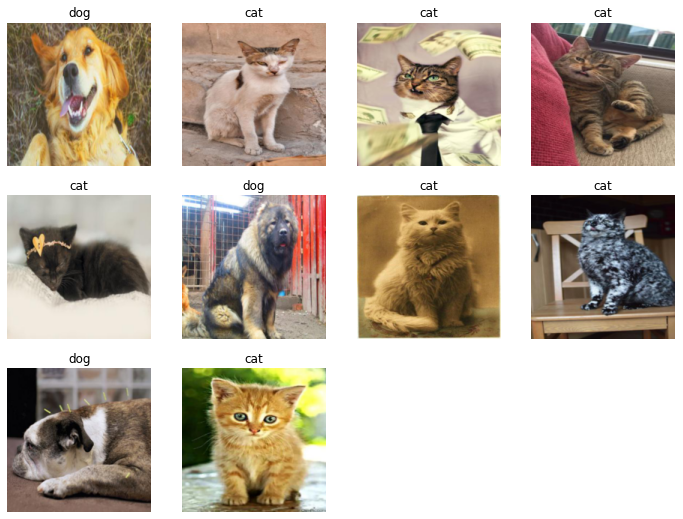

In [6]:
base='cat'
comparable='dog'
begin_search(base,comparable)

In [7]:
search(base)

There were 6 failed images


epoch,train_loss,valid_loss,error_rate,time
0,0.811017,0.341210,0.099099,00:53


epoch,train_loss,valid_loss,error_rate,time
0,0.203711,0.236223,0.072072,01:15
1,0.122500,0.255226,0.054054,01:15
2,0.081101,0.252893,0.045045,01:15
3,0.060439,0.249118,0.054054,01:15


FileNotFoundError: ignored

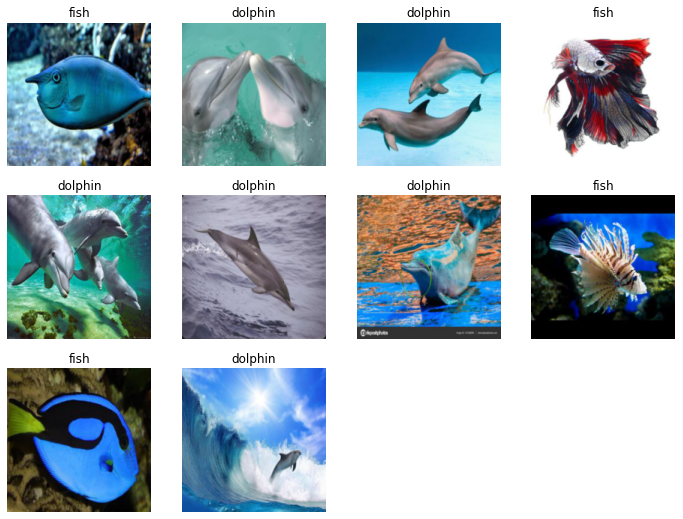

In [10]:
base='fish'
comparable='dolphin'
begin_search(base,comparable)

There were 3 failed images


epoch,train_loss,valid_loss,error_rate,time
0,1.117802,0.228767,0.135135,00:17


epoch,train_loss,valid_loss,error_rate,time
0,0.426903,0.148456,0.054054,00:26
1,0.265307,0.119180,0.054054,00:24


This is a" fish.
Probability it is a fish: 0.9979


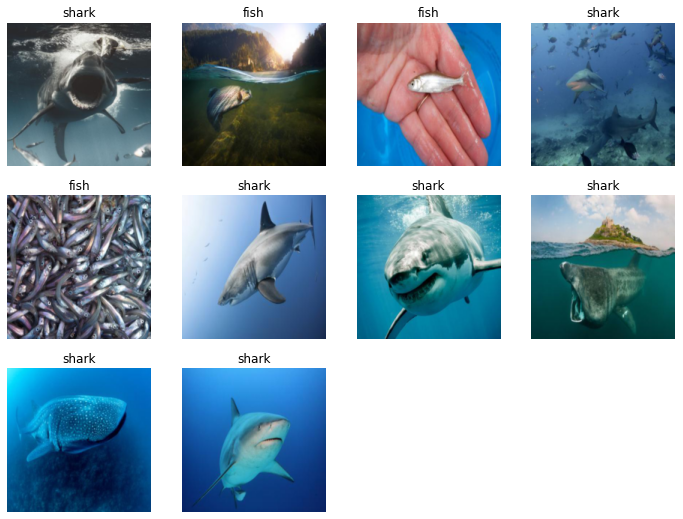

In [15]:
base='fish'
comparable='shark'
begin_search(base,comparable)

There were 8 failed images


epoch,train_loss,valid_loss,error_rate,time
0,1.080094,0.696622,0.271930,00:56


epoch,train_loss,valid_loss,error_rate,time
0,0.566134,0.523067,0.201754,01:16
1,0.421564,0.513952,0.201754,01:16
2,0.289225,0.587625,0.210526,01:15
3,0.213155,0.604543,0.210526,01:16
4,0.165066,0.594623,0.210526,01:19


This is a tea.
Probability it is a tea: 0.0002


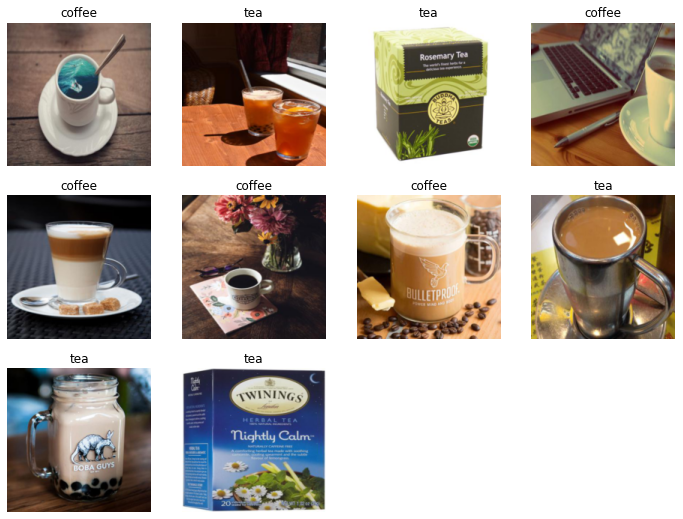

In [18]:
base='tea'
comparable='coffee'
begin_search(base,comparable)